In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots the pT of the trijet system in each event with mass closest to 172.5, as well as the maximum b-tag among the three plotted jets.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet [GeV]", 50, 15, 200)
        b_tag_axis = hist.Bin("b_tag", "b-tagging discriminant", 50, 0, 1)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'b_tag': hist.Hist("Counts", dataset_axis, b_tag_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        jets = events.Jet
        
        # Closest calculates the distance from 172.5 of a group of masses, finds the minimum distance, then returns a Boolean array of the original input array shape with True where the minimum-distance mass is located.
        def closest(masses):
            delta = abs(172.5 - masses)
            closest_masses = delta.min()
            is_closest = (delta == closest_masses)
            return is_closest
        
        # We're going to be generating combinations of three jets - that's a lot, and cutting pt off at 30 reduces jets by half.
        cut_jets = jets[jets.pt > 30]
        
        # Get all combinations of three jets.
        trijets = cut_jets.choose(3)
        # Get combined masses of those combinations, by adding all p4's and then taking .mass.
        trijet_masses = (trijets.i0 + trijets.i1 + trijets.i2).mass
        # Get the masses closest to specified value (see function above)
        is_closest = closest(trijet_masses)
        closest_trijets = trijets[is_closest]
        # Get pt of the closest trijets.
        closest_pt = (closest_trijets.i0 + closest_trijets.i1 + closest_trijets.i2).pt
        # Get btag of the closest trijets. np.maximum(x,y) compares two arrays and gets element-wise maximums. We make two comparisons - once between the first and second jet, then between the first comparison and the third jet.
        closest_btag = np.maximum(np.maximum(closest_trijets.i0.btag, closest_trijets.i1.btag), closest_trijets.i2.btag)
        
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=closest_pt.flatten())
        output['b_tag'].fill(dataset=dataset, b_tag=closest_btag.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

from dask.distributed import Client
from coffea_casa import CoffeaCasaCluster

cluster = CoffeaCasaCluster()
cluster.adapt(minimum=4, maximum=16)
client = Client(cluster)

output = processor.run_uproot_job(fileset=fileset, 
                       treename="Events", 
                       processor_instance=Processor(),
                       executor=processor.dask_executor,
                       executor_args={'client': client, 'nano': True},
                       chunksize=250000)

{'protocol': 'tls://', 'security': Security(require_encryption=True, tls_ca_file='/etc/cmsaf-secrets/ca.pem', tls_client_cert='/etc/cmsaf-secrets/hostcert.pem', tls_client_key='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_cert='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_key='/etc/cmsaf-secrets/hostcert.pem', tls_worker_cert='/etc/cmsaf-secrets/hostcert.pem', tls_worker_key='/etc/cmsaf-secrets/hostcert.pem'), 'log_directory': 'logs', 'silence_logs': 'DEBUG', 'scheduler_options': {'port': 8786, 'dashboard_address': '8787', 'protocol': 'tls', 'external_address': 'tls://matousadamec-40gmail-2ecom.dask.coffea.casa:8786'}, 'job_extra': {'universe': 'docker', 'docker_image': 'coffeateam/coffea-casa-analysis:0.2.23', 'container_service_names': 'dask', 'dask_container_port': 8786, 'transfer_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/cmsaf-secrets/xcache_token', 'encrypt_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/c

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tls://192.168.145.131:8786
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-a5540429-f2ca-11ea-9c4a-ae5d2030f5f0
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 56.9s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32854', name: htcondor--7504830.0--, memory: 0, processing: 1>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32854
distributed.core - INFO - Starting established connection


[#                                       ] | 2% Completed | 24.8sin 11.4s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32855', name: htcondor--7504831.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32855
distributed.core - INFO - Starting established connection


[#                                       ] | 3% Completed | 28.8s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.206:32781', name: htcondor--7504833.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.206:32781
distributed.core - INFO - Starting established connection


[###############################         ] | 78% Completed |  2min 43.7s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.82:32768', name: htcondor--7504832.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.82:32768
distributed.core - INFO - Starting established connection


[#####################################   ] | 93% Completed |  3min  3.4s

distributed.scheduler - INFO - Retire worker names ('htcondor--7504830.0--',)
distributed.scheduler - INFO - Retire workers {<Worker 'tls://129.93.182.3:32854', name: htcondor--7504830.0--, memory: 11, processing: 3>}
distributed.scheduler - INFO - Moving 10 keys to other workers
distributed.scheduler - INFO - Remove worker <Worker 'tls://129.93.182.3:32854', name: htcondor--7504830.0--, memory: 11, processing: 3>


[#####################################   ] | 93% Completed |  3min  3.5s

distributed.core - INFO - Removing comms to tls://129.93.182.3:32854


[#####################################   ] | 94% Completed |  3min  5.5s

distributed.scheduler - INFO - Retire worker names ('htcondor--7504832.0--',)
distributed.scheduler - INFO - Retire workers {<Worker 'tls://129.93.182.82:32768', name: htcondor--7504832.0--, memory: 7, processing: 3>}
distributed.scheduler - INFO - Moving 6 keys to other workers
distributed.scheduler - INFO - Remove worker <Worker 'tls://129.93.182.82:32768', name: htcondor--7504832.0--, memory: 7, processing: 3>
distributed.core - INFO - Removing comms to tls://129.93.182.82:32768


[######################################  ] | 97% Completed |  3min 11.5s

distributed.scheduler - INFO - Retire worker names ('htcondor--7504831.0--',)
distributed.scheduler - INFO - Retire workers {<Worker 'tls://129.93.182.3:32855', name: htcondor--7504831.0--, memory: 5, processing: 1>}
distributed.scheduler - INFO - Moving 4 keys to other workers
distributed.scheduler - INFO - Remove worker <Worker 'tls://129.93.182.3:32855', name: htcondor--7504831.0--, memory: 5, processing: 1>
distributed.core - INFO - Removing comms to tls://129.93.182.3:32855


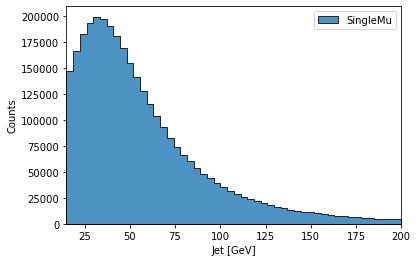

In [4]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

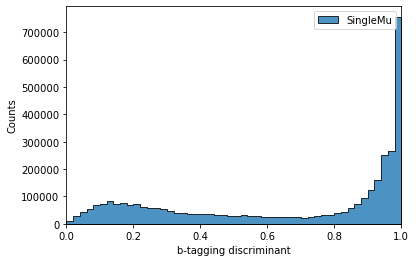

In [5]:
hist.plot1d(output['b_tag'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})